In [23]:
#Terminating is any previous session is still active
import os
if os.path.exists('session.session'):
    os.remove('session.session')

In [ ]:
!pip install telethon nest_asyncio

In [16]:
import pandas as pd
from telethon import TelegramClient
from telethon.tl.functions.messages import GetHistoryRequest
import os

api_id = 25283000
api_hash = '0d6932aa2d65dd6abcd6882b0542b19b'
target_channel = '@financialtimeschannel'

client = TelegramClient('session', api_id, api_hash)

async def scrape_telegram_data():
    async with client:
        entity = await client.get_entity(target_channel)
        messages = []
        offset_id = 0
        limit_per_batch = 100  # Max limit per batch, but we can repeat until 2000
        total_limit = 5000  # Total number of messages to fetch

        print(f"Scraping messages from: {target_channel}")
        print(f"Entity: {entity}")

        while len(messages) < total_limit:
            history = await client(GetHistoryRequest(
                peer=entity,
                offset_id=offset_id,
                offset_date=None,
                add_offset=0,
                limit=limit_per_batch,  # Set to 100, but it will fetch in multiple batches.
                max_id=0,
                min_id=0,
                hash=0
            ))

            if not history.messages:
                print("No more messages found.")
                break

            # Appending the fetched messages
            for message in history.messages:
                if message.message:  # Include only text messages
                    messages.append({
                        'date': message.date,
                        'sender_id': message.sender_id,
                        'text': message.message
                    })

            offset_id = history.messages[-1].id
            print(f"Fetched {len(history.messages)} messages in this batch. Total messages: {len(messages)}")

            if len(messages) >= total_limit:
                break

        # Saving messages to a CSV file (append mode)
        if messages:
            df = pd.DataFrame(messages)
            # Checking if the file exists. If it does, append. Otherwise, create a new file.
            if os.path.exists('telegram_data.csv'):
                df.to_csv('telegram_data.csv', mode='a', header=False, index=False)
                print(f"Appended {len(messages)} messages to telegram_data.csv")
            else:
                df.to_csv('telegram_data.csv', mode='w', header=True, index=False)
                print(f"Scraped {len(messages)} messages and saved to telegram_data.csv")
        else:
            print("No messages scraped. Check the channel or permissions.")

# Running the scraper
import asyncio
asyncio.run(scrape_telegram_data())


Scraping messages from: @financialtimeschannel
Entity: Channel(id=1385419036, title='Financial Times', photo=ChatPhoto(photo_id=4990276575593343148, dc_id=1, has_video=False, stripped_thumb=b'\x01\x08\x08\xb4\x03\xf9jN\xed\xd9\x19\x1f\x8f4QEfY'), date=datetime.datetime(2020, 1, 21, 22, 44, 11, tzinfo=datetime.timezone.utc), creator=False, left=True, broadcast=True, verified=False, megagroup=False, restricted=False, signatures=False, min=False, scam=False, has_link=True, has_geo=False, slowmode_enabled=False, call_active=False, call_not_empty=False, fake=False, gigagroup=False, noforwards=False, join_to_send=False, join_request=False, forum=False, stories_hidden=False, stories_hidden_min=True, stories_unavailable=True, signature_profiles=False, access_hash=7338827050198741589, username='financialtimeschannel', restriction_reason=[], admin_rights=None, banned_rights=None, default_banned_rights=None, participants_count=None, usernames=[], stories_max_id=None, color=None, profile_color=Non

In [18]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

# Downloading the 'punkt_tab' data
nltk.download('punkt_tab')  # This line is added

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Loading the scraped data
df = pd.read_csv('telegram_data.csv')

# Text preprocessing function
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text.lower())
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Performing preprocessing
df['cleaned_text'] = df['text'].apply(preprocess_text)
df.to_csv('preprocessed_data.csv', index=False)
print("Preprocessed data saved to preprocessed_data.csv")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Preprocessed data saved to preprocessed_data.csv


In [19]:
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Applying sentiment analysis
df['sentiment'] = df['cleaned_text'].apply(lambda x: sia.polarity_scores(x)['compound'])
df['sentiment_label'] = df['sentiment'].apply(lambda x: 'positive' if x > 0.05 else 'negative' if x < -0.05 else 'neutral')
df.to_csv('sentiment_data.csv', index=False)
print("Sentiment analysis completed and saved to sentiment_data.csv")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Sentiment analysis completed and saved to sentiment_data.csv


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Loading sentiment data
df = pd.read_csv('sentiment_data.csv')

# Replacing NaN values in 'cleaned_text' with empty strings
df['cleaned_text'] = df['cleaned_text'].fillna('')

# Converting text into numerical features
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_text']).toarray()
y = df['sentiment_label']

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluating the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.88      0.69      0.77       421
     neutral       0.86      0.99      0.92      1274
    positive       0.96      0.85      0.90       905

    accuracy                           0.89      2600
   macro avg       0.90      0.84      0.86      2600
weighted avg       0.90      0.89      0.89      2600



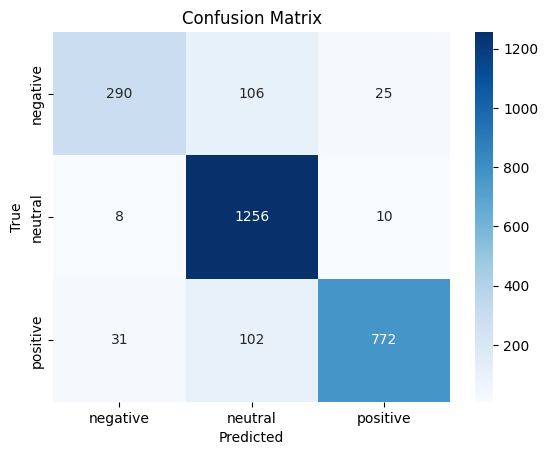

Model Accuracy: 89.15%


In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")